# RMSD

*/ Update July 2018 /*
by Alexis Salas-Burgos PhD

## MDAnalysis 
from https://www.mdanalysis.org

## MDTraj
from http://mdtraj.org

## PyTraj
from https://amber-md.github.io/pytraj/latest/index.html

## Prody
from http://prody.csb.pitt.edu

In [1]:
# Load Trajectory
import MDAnalysis as mda
import mdtraj as mdt
import pytraj as mdp
import prody as pd

/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [3]:
# DCD en formato antigüo a veces no funciona con prody ni pytraj
#from MDAnalysis.tests.datafiles import PSF, DCD, PDB
DCD = "tutorial/ubq_wb_eq.dcd"
PSF = "tutorial/ubq_wb.psf"

In [4]:
## MDAnalysis
import MDAnalysis.analysis.rms
u = MDAnalysis.Universe(PSF, DCD)
bb = u.select_atoms('backbone')
A = bb.positions  # coordinates of first frame
u.trajectory[-1]      # forward to last frame
B = bb.positions  # coordinates of last frame
MDAnalysis.analysis.rms.rmsd(A, B)

6.067594797750535

In [5]:
## MDAnalysis
# project a dynamic property on the structure using the B-factor (tempfactor) field
import numpy as np
import MDAnalysis
import MDAnalysis.analysis.align

from MDAnalysis.tests.datafiles import PSF, DCD


u = MDAnalysis.Universe(PSF, DCD)
ref = MDAnalysis.Universe(PSF, DCD)  # copy of u

CORE_selection = "resid 1-29 or resid 60-121 or resid 160-214"
pdbtrj = "adk_distance_bfac.pdb"


# workaround for Issue #1359 https://github.com/MDAnalysis/mdanalysis/issues/1359
# which will be fixed in 0.17.0
u.add_TopologyAttr(MDAnalysis.core.topologyattrs.Tempfactors(np.zeros(len(u.atoms))))


with MDAnalysis.Writer(pdbtrj, multiframe=True, bonds=None, n_atoms=u.atoms.n_atoms) as PDB:
    # reference coordinates: set to first frame
    ref.trajectory[0]
    # iterate through our trajectory
    for ts in u.trajectory:
        # superimpose on the reference CORE (at t=0)
        rmsd = MDAnalysis.analysis.align.alignto(u.atoms, ref.atoms, select=CORE_selection)
        distances = np.sqrt(np.sum((u.atoms.positions - ref.atoms.positions)**2, axis=1))
        # project displacement on structure via bfactor ("tempfactor") field
        u.atoms.tempfactors = distances
        PDB.write(u.atoms)
        print("Frame {0}: CORE RMSD before/after superposition: {1[0]:.1f} / {1[1]:.1f} A. "
              "min-max displacement: {2:.1f}...{3:.1f} A".format(ts.frame, rmsd, distances.min(), distances.max()))

print("Wrote PDB trajectory {0} with distances in bfactor field".format(pdbtrj))

/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'altLocs' Using default value of ' '
  "".format(attrname, default))
/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))
/usr/local/anaconda3/envs/bio/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'occupancies' Using default value of '1.0'
  "".format(attrname, default))


Frame 0: CORE RMSD before/after superposition: 0.0 / 0.0 A. min-max displacement: 0.0...0.0 A
Frame 1: CORE RMSD before/after superposition: 0.7 / 0.7 A. min-max displacement: 0.0...3.5 A
Frame 2: CORE RMSD before/after superposition: 0.8 / 0.8 A. min-max displacement: 0.0...3.6 A
Frame 3: CORE RMSD before/after superposition: 1.0 / 1.0 A. min-max displacement: 0.0...4.2 A
Frame 4: CORE RMSD before/after superposition: 1.1 / 1.0 A. min-max displacement: 0.0...4.7 A
Frame 5: CORE RMSD before/after superposition: 1.1 / 1.1 A. min-max displacement: 0.0...6.3 A
Frame 6: CORE RMSD before/after superposition: 1.2 / 1.1 A. min-max displacement: 0.1...6.4 A
Frame 7: CORE RMSD before/after superposition: 1.3 / 1.2 A. min-max displacement: 0.1...7.2 A
Frame 8: CORE RMSD before/after superposition: 1.3 / 1.2 A. min-max displacement: 0.1...7.3 A
Frame 9: CORE RMSD before/after superposition: 1.4 / 1.3 A. min-max displacement: 0.0...6.6 A
Frame 10: CORE RMSD before/after superposition: 1.5 / 1.3 A.

In [7]:
## View pdb with beta color (PENDIENTE)
import nglview as nv
traj = mdp.load("/Users/alsalas/GDrive/Jupyter/Dynamics/Trayectorias/adk_distance_bfac.pdb")
print(traj)
view = nv.show_pytraj(traj)
view._set_color_by_residue(colors="blue")
# reset representation
view

pytraj.Trajectory, 98 frames: 
Size: 0.007318 (GB)
<Topology: 3341 atoms, 214 residues, 1 mols, non-PBC>
           


NGLWidget(count=98)

Max pairwise rmsd: 0.688113 nm
PLOT RMSD Clustering:


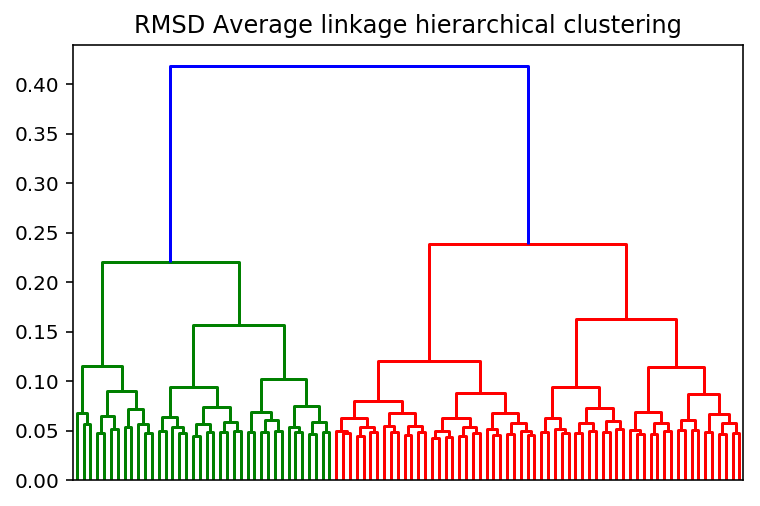

In [6]:
## MDTraj
from MDAnalysis.tests.datafiles import PSF, DCD, PDB

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 

import mdtraj as mdt
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform

t = mdt.load(DCD, top=PSF)
atom_indices = [a.index for a in t.topology.atoms if a.element.symbol != 'H']
distances = np.empty((t.n_frames, t.n_frames))

for i in range(t.n_frames):
    distances[i] = mdt.rmsd(t, t, i, atom_indices=atom_indices)
    #distances[i] = mdt.rmsd(t, t, i, atom_indices=atom_indices, precentered=True)
    #distances[i] = mdt.rmsd_qcp(t.xyz[0], t.xyz[i])
print('Max pairwise rmsd: %f nm' % np.max(distances))


print('PLOT RMSD Clustering:')

# Clustering only accepts reduced form. Squareform's checks are too stringent
#assert np.all(distances - distances.T < 1e-6)
assert np.all(distances - distances.T < 1e-4)
reduced_distances = squareform(distances, checks=False)

linkage = scipy.cluster.hierarchy.linkage(reduced_distances, method='average')
plt.title('RMSD Average linkage hierarchical clustering')
_ = scipy.cluster.hierarchy.dendrogram(linkage, no_labels=True, count_sort='descendent')

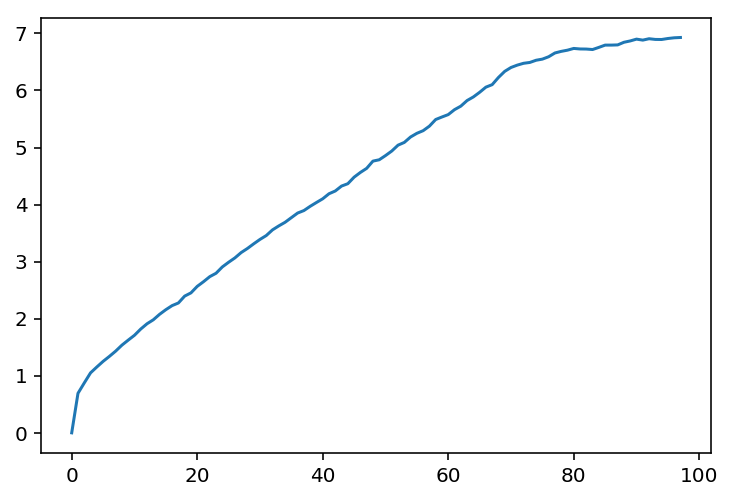

In [7]:
## PyTraj
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import pytraj as mdp
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.tests.datafiles import PSF, DCD, PDB
p = mdp.load(DCD, PSF)

mdp.rmsd(p, mask=['@CA', '@C', ':3-18@CA'], dtype='dataset')
RMSD = mdp.rmsd(p, ref=p[0])
plt.plot(RMSD)

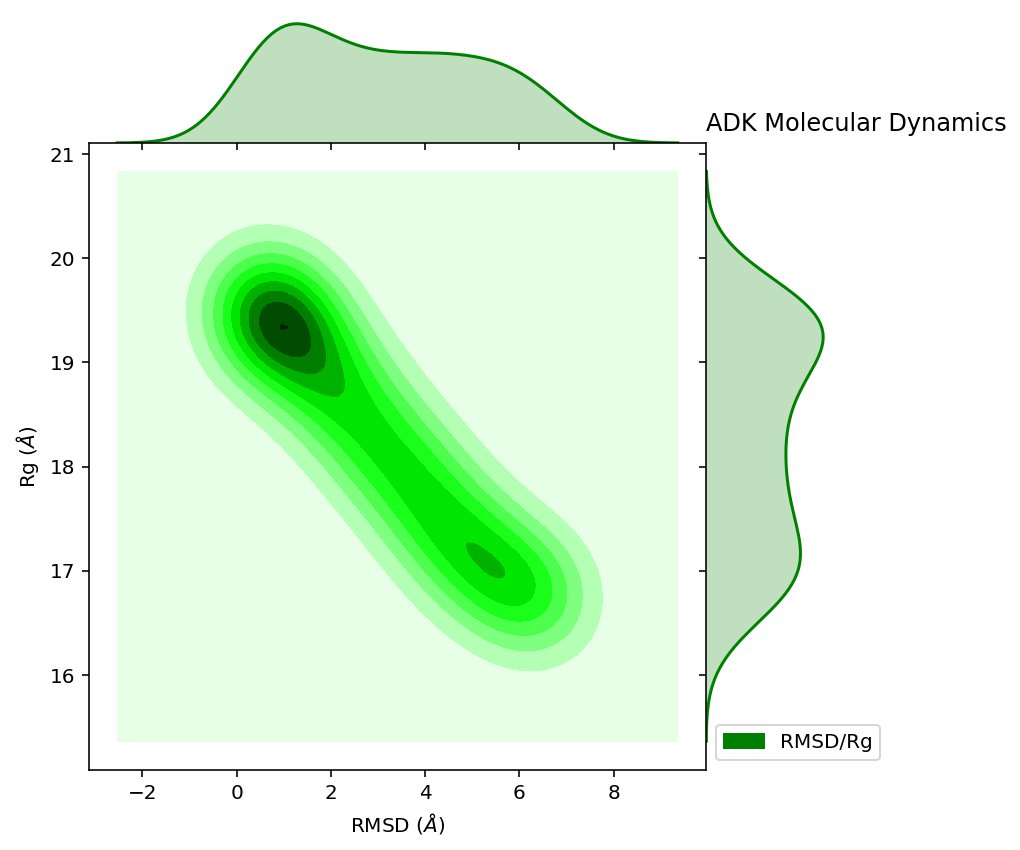

In [8]:
## PyTraj
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from MDAnalysis.tests.datafiles import PSF, DCD, PDB
p = mdp.load(DCD, PSF)

# caculate rmsd to 1st frame, use only backbone atoms
rmsd_data = mdp.rmsd(p, ref=-1, mask='@C,N,O')
# calculate radgyr for all atoms
rg_data = mdp.radgyr(p)

df = pandas.DataFrame({"RMSD":rmsd_data, "Rg":rg_data})
#sns.jointplot(rmsd_data, rg_data, kind="hex", color="#4CB391")
#sns.jointplot(rmsd_data, rg_data, color="#31a354")
plot1 = sns.jointplot(x="RMSD", y="Rg", data=df, kind="kde", space=0, color="g")
plot1.set_axis_labels("RMSD ($\AA$)", "Rg ($\AA$)")

plt.title('ADK Molecular Dynamics', loc="left")
red_patch = mpatches.Patch(color='Green', label='RMSD/Rg')
plt.legend(handles=[red_patch], loc=3)
plt.show()

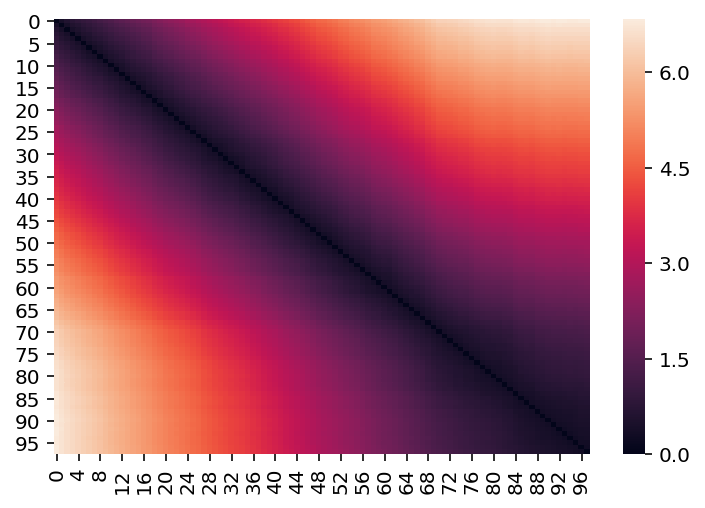

In [9]:
## PyTraj
# Pairwise RMSD
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
import matplotlib
import seaborn as sns
from MDAnalysis.tests.datafiles import PSF, DCD, PDB
p = mdp.load(DCD, PSF)
mat = mdp.pairwise_rmsd(p, '@CA')
sns.heatmap(mat)

In [10]:
## Prody
# Load trajectory
import prody as pd
DCD = "tutorial/ubq_wb_eq.dcd"
PSF = "tutorial/ubq_wb.psf"
PDB = "tutorial/ubq_wb.pdb"

ensemble = pd.parseDCD(DCD)
structure = pd.parsePDB(PDB)
ensemble.setAtoms(structure)
ensemble.setCoords(structure)

ensemble.superpose()
# All atoms
rmsd = ensemble.getRMSDs()
rmsf = ensemble.getRMSFs()
# Calpha
ensemble.setAtoms(structure.calpha)
ensemble.superpose()
rmsd_ca = ensemble.getRMSDs()
rmsf_ca = ensemble.getRMSFs()

@> WARNING DCD header claims 0 frames, file size indicates there are actually 100 frames.
@> DCD file contains 100 coordinate sets for 7051 atoms.
@> DCD file was parsed in 0.02 seconds.
@> 8.08 MB parsed at input rate 480.93 MB/s.
@> 100 coordinate sets parsed at input rate 5954 frame/s.
@> 7051 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> Superposition completed in 0.25 seconds.
@> Superposition completed in 0.23 seconds.


@> WARNING DCD header claims 0 frames, file size indicates there are actually 100 frames.
@> 7051 atoms and 1 coordinate set(s) were parsed in 0.07s.


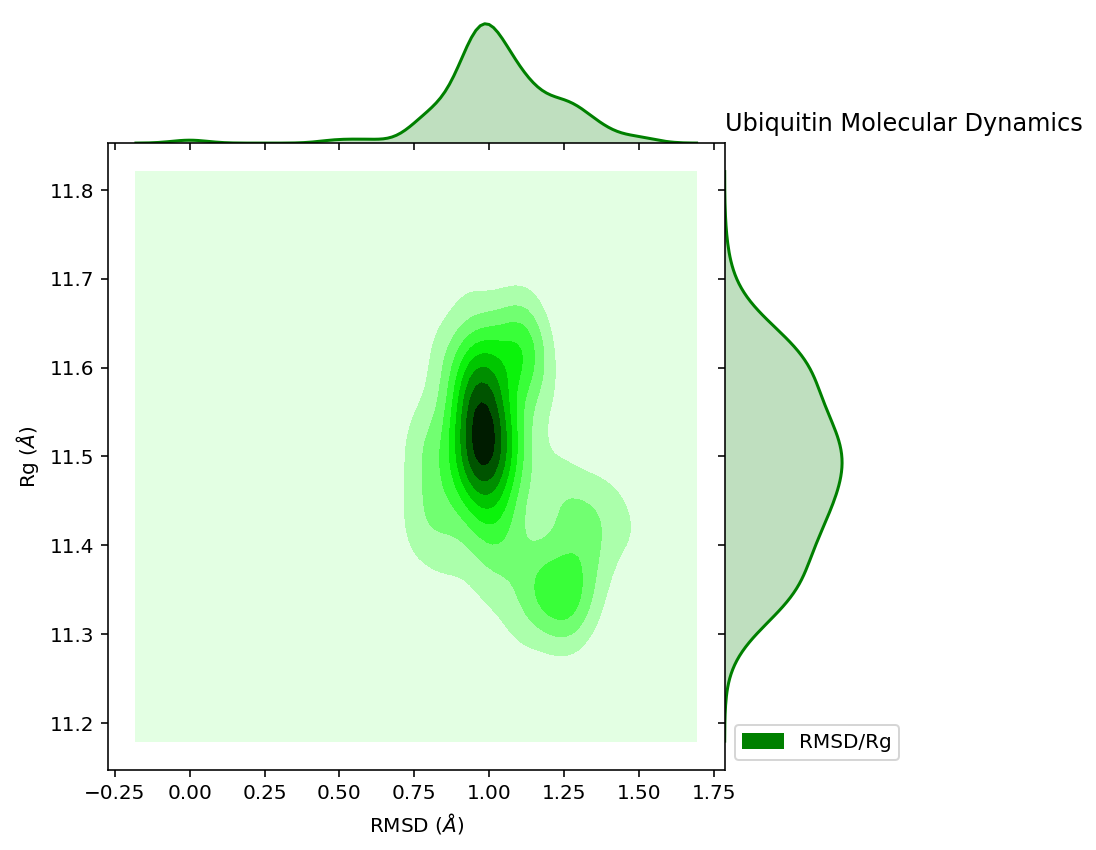

In [12]:
## Prody
# caculate rmsd to 1st frame, use only backbone atoms
DCD = "tutorial/ubq_wb_eq.dcd"
PSF = "tutorial/ubq_wb.psf"
PDB = "tutorial/ubq_wb.pdb"

traj = pd.Trajectory(DCD)
structure = pd.parsePDB(PDB)
traj.link(structure)
traj.setAtoms(structure.calpha)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

rg_data = np.zeros(len(traj))
rmsd_data = np.zeros(len(traj))
for i, frame in enumerate(traj):
    rg_data[i] = pd.calcGyradius( frame )
    frame.superpose()
    rmsd_data[i] = frame.getRMSD()    

df = pandas.DataFrame({"RMSD":rmsd_data, "Rg":rg_data})
#sns.jointplot(rmsd_data, rg_data, kind="hex", color="#4CB391")
#sns.jointplot(rmsd_data, rg_data, color="#31a354")
plot1 = sns.jointplot(x="RMSD", y="Rg", data=df, kind="kde", space=0, color="g")
plot1.set_axis_labels("RMSD ($\AA$)", "Rg ($\AA$)")

plt.title('Ubiquitin Molecular Dynamics', loc="left")
red_patch = mpatches.Patch(color='Green', label='RMSD/Rg')
plt.legend(handles=[red_patch], loc=3)
plt.show()